# Autoencoder for Classification
The autoencoder approach for classification is similar to anomaly detection. In anomaly detection, we learn the pattern of a normal process. Anything that does not follow this pattern is classified as an anomaly. For a binary classification of rare events, we can use a similar approach using autoencoders.

## Quick revision: What is an autoencoder?
* An autoencoder is made of two modules: encoder and decoder.
* The encoder learns the underlying features of a process. These features are typically in a reduced dimension.
* The decoder can recreate the original data from these underlying features.

### How to use an Autoencoder rare-event classification?
* We will divide the data into two parts: positively labeled and negatively labeled.
* The negatively labeled data is treated as normal state of the process. A normal state is when the process is eventless.
* We will ignore the positively labeled data, and train an Autoencoder on only negatively labeled data.
* This Autoencoder has now learned the features of the normal process.
* A well-trained Autoencoder will predict any new data that is coming from the normal state of the process (as it will have the same pattern or distribution).
* Therefore, the reconstruction error will be small.
* However, if we try to reconstruct a data from a rare-event, the Autoencoder will struggle.
* This will make the reconstruction error high during the rare-event.
* We can catch such high reconstruction errors and label them as a rare-event prediction.
* This procedure is similar to anomaly detection methods.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pylab import rcParams
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed
seed(1)

import tensorflow
tensorflow.random.set_seed(2)

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

### Data preprocessing


The data is taken from https://arxiv.org/abs/1809.10717.

In [2]:
df = pd.read_csv("processminer-rare-event-mts - data.csv")

In [3]:
df.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


The objective of this rare-event problem is to predict a sheet-break before it occurs. We will try to predict the break 4 minutes in advance. 

To build this model, we will shift the labels 2 rows up (which corresponds to 4 minutes). We can do this as df.y=df.y.shift(-2). However, in this problem we would want to do the shifting as: if row n is positively labeled,
Make row (n-2) and (n-1) equal to 1. This will help the classifier learn up to 4 minute ahead prediction.

Delete row n. Because we do not want the classifier to learn predicting a break when it has happened.
We will develop the following UDF for this curve shifting.

In [4]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [5]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


,time,y,x1,x2,x3
256,5/1/99 8:32,0,1.016235,-4.058394,-1.097158
257,5/1/99 8:34,0,1.005602,-3.876199,-1.074373
258,5/1/99 8:36,0,0.933933,-3.868467,-1.249954
259,5/1/99 8:38,1,0.892311,-13.332664,-10.006578
260,5/1/99 10:50,0,0.020062,-3.987897,-1.248529


After shifting


,y,time,x1,x2,x3
255,0.0,5/1/99 8:30,0.997107,-3.865720,-1.133779
256,0.0,5/1/99 8:32,1.016235,-4.058394,-1.097158
257,1.0,5/1/99 8:34,1.005602,-3.876199,-1.074373
258,1.0,5/1/99 8:36,0.933933,-3.868467,-1.249954
260,0.0,5/1/99 10:50,0.020062,-3.987897,-1.248529


Before moving forward, we will drop the time, and also the categorical columns for simplicity.


In [6]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

Now, we divide the data into train, valid, and test sets. Then we will take the subset of data with only 0s to train the autoencoder.

### Divide the data into train, valid, and test


In [7]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In the autoencoder, we will be encoding only the negatively labeled data. That is, we will take the part of data for which y=0 and build an autoencoder. For that, we will divide the datasets as following.



In [8]:
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

### Standardization
It is usually better to use a standardized data (transformed to Gaussian, mean 0 and variance 1) for autoencoders.

In [9]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

## Autoencoder Classifier
### Initialization

First, we will initialize the Autoencoder architecture. We are building a simple autoencoder. More complex architectures and other configurations should be explored

In [10]:
nb_epoch = 200
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 59)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                1920      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 59)                1947      
Total params: 5,211
Trainable params: 5,211
Non-trainable params: 0
___________________________________________________________

### Training

In [11]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Epoch 1/200
91/91 [==============================] - 14s 11ms/step - loss: 0.9746 - accuracy: 0.0374 - val_loss: 0.6980 - val_accuracy: 0.0489
Epoch 2/200
91/91 [==============================] - 1s 6ms/step - loss: 0.6249 - accuracy: 0.0818 - val_loss: 0.4773 - val_accuracy: 0.1443
Epoch 3/200
91/91 [==============================] - 1s 6ms/step - loss: 0.4478 - accuracy: 0.1757 - val_loss: 0.3893 - val_accuracy: 0.2175
Epoch 4/200
91/91 [==============================] - 1s 7ms/step - loss: 0.3643 - accuracy: 0.2356 - val_loss: 0.3351 - val_accuracy: 0.2647
Epoch 5/200
91/91 [==============================] - 1s 6ms/step - loss: 0.3190 - accuracy: 0.2837 - val_loss: 0.3057 - val_accuracy: 0.3181
Epoch 6/200
91/91 [==============================] - 1s 6ms/step - loss: 0.2930 - accuracy: 0.3277 - val_loss: 0.2846 - val_accuracy: 0.3392
Epoch 7/200
91/91 [==============================] - 1s 7ms/step - loss: 0.2717 - accuracy: 0.3505 - val_loss: 0.2672 - val_accuracy: 0.3538
Epoch 8/200

Epoch 59/200
91/91 [==============================] - 1s 6ms/step - loss: 0.1260 - accuracy: 0.5818 - val_loss: 0.1325 - val_accuracy: 0.5532
Epoch 60/200
91/91 [==============================] - 1s 7ms/step - loss: 0.1267 - accuracy: 0.5752 - val_loss: 0.1309 - val_accuracy: 0.5689
Epoch 61/200
91/91 [==============================] - 1s 6ms/step - loss: 0.1255 - accuracy: 0.5727 - val_loss: 0.1300 - val_accuracy: 0.5643
Epoch 62/200
91/91 [==============================] - 1s 6ms/step - loss: 0.1274 - accuracy: 0.5910 - val_loss: 0.1297 - val_accuracy: 0.5720
Epoch 63/200
91/91 [==============================] - 1s 7ms/step - loss: 0.1252 - accuracy: 0.5793 - val_loss: 0.1290 - val_accuracy: 0.5574
Epoch 64/200
91/91 [==============================] - 1s 6ms/step - loss: 0.1247 - accuracy: 0.5790 - val_loss: 0.1290 - val_accuracy: 0.5588
Epoch 65/200
91/91 [==============================] - 1s 7ms/step - loss: 0.1256 - accuracy: 0.5816 - val_loss: 0.1277 - val_accuracy: 0.5671
Epoch 

91/91 [==============================] - 1s 7ms/step - loss: 0.1043 - accuracy: 0.6024 - val_loss: 0.1070 - val_accuracy: 0.5876
Epoch 117/200
91/91 [==============================] - 1s 7ms/step - loss: 0.1041 - accuracy: 0.5985 - val_loss: 0.1065 - val_accuracy: 0.5858
Epoch 118/200
91/91 [==============================] - 1s 7ms/step - loss: 0.1017 - accuracy: 0.6046 - val_loss: 0.1069 - val_accuracy: 0.5963
Epoch 119/200
91/91 [==============================] - 1s 7ms/step - loss: 0.1038 - accuracy: 0.6062 - val_loss: 0.1057 - val_accuracy: 0.5803
Epoch 120/200
91/91 [==============================] - 1s 7ms/step - loss: 0.1056 - accuracy: 0.6048 - val_loss: 0.1060 - val_accuracy: 0.5980
Epoch 121/200
91/91 [==============================] - 1s 7ms/step - loss: 0.1044 - accuracy: 0.6088 - val_loss: 0.1054 - val_accuracy: 0.5987
Epoch 122/200
91/91 [==============================] - 1s 7ms/step - loss: 0.1029 - accuracy: 0.5969 - val_loss: 0.1052 - val_accuracy: 0.5907
Epoch 123/200

91/91 [==============================] - 1s 7ms/step - loss: 0.0962 - accuracy: 0.6222 - val_loss: 0.0965 - val_accuracy: 0.6087
Epoch 174/200
91/91 [==============================] - 1s 7ms/step - loss: 0.0936 - accuracy: 0.6151 - val_loss: 0.0960 - val_accuracy: 0.6108
Epoch 175/200
91/91 [==============================] - 1s 7ms/step - loss: 0.0930 - accuracy: 0.6152 - val_loss: 0.0974 - val_accuracy: 0.6060
Epoch 176/200
91/91 [==============================] - 1s 7ms/step - loss: 0.0944 - accuracy: 0.6092 - val_loss: 0.0963 - val_accuracy: 0.6139
Epoch 177/200
91/91 [==============================] - 1s 7ms/step - loss: 0.0935 - accuracy: 0.6183 - val_loss: 0.0966 - val_accuracy: 0.6087
Epoch 178/200
91/91 [==============================] - 1s 7ms/step - loss: 0.0947 - accuracy: 0.6186 - val_loss: 0.0974 - val_accuracy: 0.6046
Epoch 179/200
91/91 [==============================] - 1s 7ms/step - loss: 0.0937 - accuracy: 0.6200 - val_loss: 0.0967 - val_accuracy: 0.6049
Epoch 180/200

In [12]:
autoencoder = load_model('autoencoder_classifier.h5')

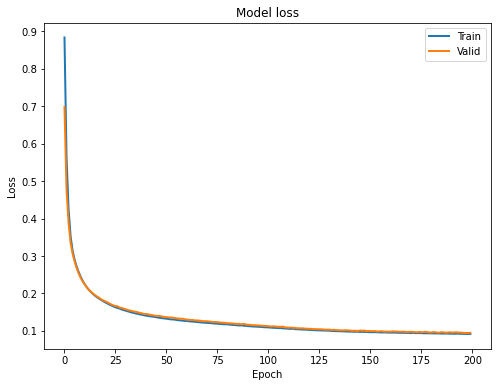

In [13]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Classification

In the following, we show how we can use an Autoencoder reconstruction error for the rare-event classification.
As mentioned before, if the reconstruction error is high, we will classify it as a sheet-break. We will need to determine the threshold for this.
We will use the validation set to identify the threshold.

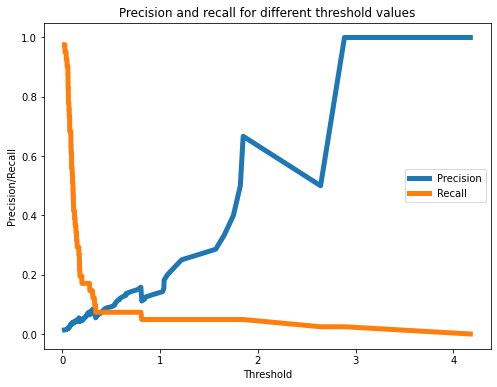

In [14]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Now, we will perform classification on the test data.

**We should not estimate the classification threshold from the test data. It will result in overfitting.**

In [15]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()

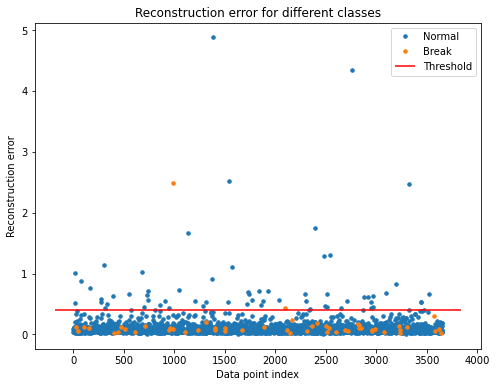

In [16]:
threshold_fixed = 0.4
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

the orange and blue dot above the threshold line represents the True Positive and False Positive, respectively. As we can see, we have good number of false positives. To have a better look, we can see a confusion matrix.

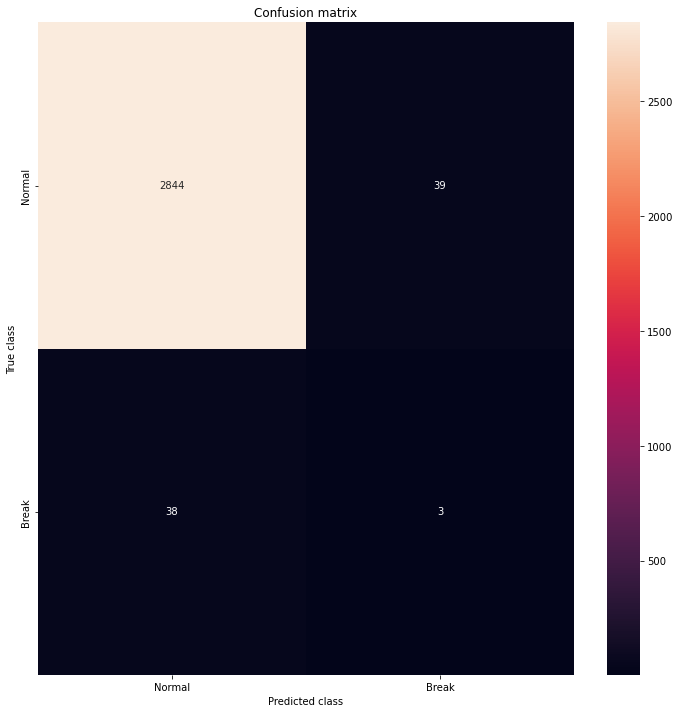

In [17]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

We could predict 8 out of 41 breaks instances. Note that these instances include 2 or 4 minute ahead predictions. This is around 20%, which is a good recall rate for the paper industry. The False Positive Rate is around 6%. This is not ideal but not terrible for a mill.

Still, this model can be further improved to increase the recall rate with smaller False Positive Rate. We will look at the AUC below and then talk about the next approach for improvement.

### ROC curve and AUC


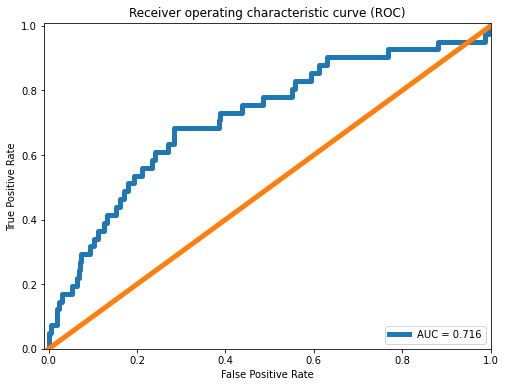

In [18]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()